# Figure 2C for metapredict V3 manuscript 2024

In [3]:
import os
import random
import metapredict as meta
import numpy as np
import matplotlib
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_recall_curve
import protfasta
from scipy.stats import norm, gaussian_kde
from collections import defaultdict
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'
# set fonts
font = {'family' : 'arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

# set colors for plots here. Colors are for V1, v2, and v3. Chosen because Ryan can differentiate them.
v1color='#FF9D33'
v2color='#FF6433'
v3color='#CC2D46'
hybridcolor='black'
pLDDT_color='blue'


/Users/ryanemenecker/miniconda3/envs/hh1/lib/python3.8/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [4]:

# read in data.
def read_in_tsv(path_to_tsv):
    per_protein=[]
    total_proteome=[]
    with open(path_to_tsv) as fh:
        lines=fh.read().split('\n')
    fh.close()
    for l in lines[1:]:
        if l != '':
            if len (l.split('\t'))==3:
                vals=l.split('\t')
                per_protein.append(float(vals[1]))
                total_proteome.append(float(vals[2]))
    return {'per_protein':per_protein, 'total_proteome':total_proteome}


archaea_infecting=read_in_tsv('archaeal_infecting_viruses.tsv')
bacteria_infecting=read_in_tsv('bacterial_infecting_viruses.tsv')
eukaryotic_infecting=read_in_tsv('eukaryotic_infecting_viruses.tsv')
human_infecting=read_in_tsv('human_infecting_viruses.tsv')
ecoli_infecting=read_in_tsv('ecoli_infecting_viruses.tsv')

In [5]:
# functions to help with graphing points and spreading them out on the scatterplot.    
def generate_density_based_scatter_data(y_values, center=0, base_width=1.0, scale_factor=2.0, abs_range=0.3):
    """
    Generates X values for a scatter plot where denser areas on the Y-axis are spread wider on the X-axis.
    
    Parameters:
    y_values (list or array): Input Y values.
    center (float): The center of the X-axis distribution (default: 0).
    base_width (float): Base width of the X distribution for the sparsest areas (default: 1.0).
    scale_factor (float): Factor to scale the X width based on local density (default: 2.0).
    abs_range (float) : absolute range +/- the center a value can be
    Returns:
    tuple: X and Y values to plot.
    """
    # Calculate the density of Y values using a Gaussian KDE
    kde = gaussian_kde(y_values)
    
    # Evaluate the density for each Y value
    density = kde(y_values)
    
    # Normalize density to [0, 1] range to scale the X-axis width
    density_normalized = (density - density.min()) / (density.max() - density.min())
    
    # Generate X values based on the local density of Y values
    x_spread = base_width + scale_factor * density_normalized
    x_values = np.random.normal(loc=center, scale=x_spread, size=len(y_values))
    
    
    return x_values, y_values


In [6]:
#combine archaea and bacteria int prokaryotes
per_protein=[]
total_proteome=[]
for i in archaea_infecting['per_protein']:
    per_protein.append(i)
for i in bacteria_infecting['per_protein']:
    per_protein.append(i)
for i in archaea_infecting['total_proteome']:
    total_proteome.append(i)
for i in bacteria_infecting['total_proteome']:
    total_proteome.append(i)  
prokaryote_infecting={'total_proteome':total_proteome, 'per_protein':per_protein}

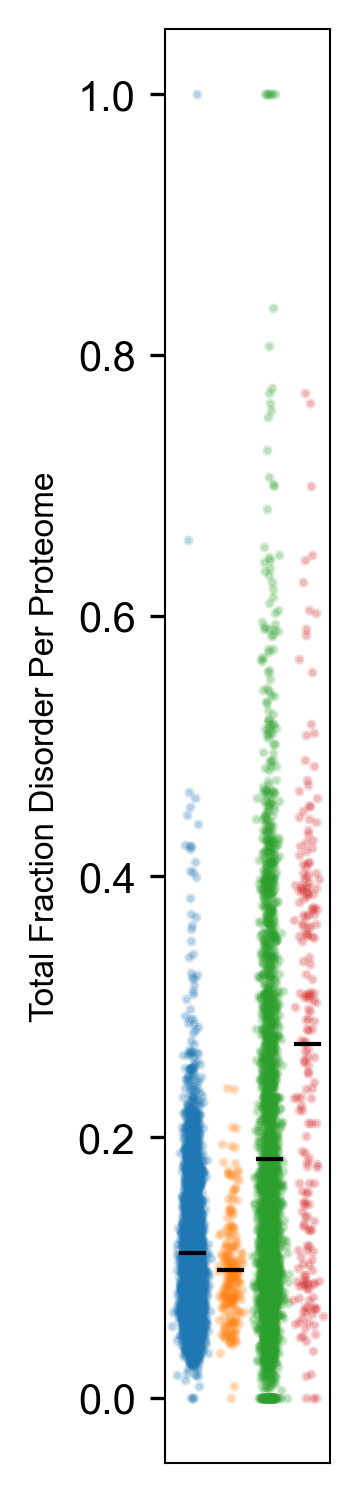

In [7]:
# set per protein or total proteome
disorder_vals='total_proteome'

if disorder_vals=='per_protein':
    # AFPP = Average fraction per protein across the proteome.
    graph_tag='AFPP'
    ylabel='Average Fraction Disorder Per Protein Per Proteome'
elif disorder_vals=='total_proteome':
    # TFAP = Total fraction across proteome
    graph_tag='TFAP'
    ylabel='Total Fraction Disorder Per Proteome'

proteomes={'Prokaryote infecting':prokaryote_infecting, 'E. coli infecting':ecoli_infecting,
           'Eukaryote infecting': eukaryotic_infecting, 'H. sapiens infecting':human_infecting}
fig, per_prot=plt.subplots(ncols=1, nrows=1, figsize=(1.3, 5.08), dpi=150, facecolor='w', edgecolor='k')
for n, p in enumerate(proteomes): 
    x_values, y_values=generate_density_based_scatter_data(proteomes[p][disorder_vals], 
                                                           center=n, base_width=0.1, scale_factor=0.05)
    per_prot.scatter(x_values, y_values, marker='.', s=8, alpha=0.2)
    avg=np.mean(y_values)
    per_prot.plot([n-0.3, n+0.3], [avg,avg], color='black', linewidth=1)

#per_prot.set_xticks([a for a in range(0, len(proteomes.keys()))], 
#                    list(proteomes.keys()), rotation=90, linespacing=0.7)
per_prot.set_xticks([])
per_prot.set_ylabel(ylabel, fontsize=8)
plt.tight_layout()
plt.savefig(f'prokaryote_vs_eukaryote_infecting_viruses_{graph_tag}.pdf')

# statistical testing

In [8]:
# imports for statistical testing
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import shapiro

## step 1 - determine if our data is normal. This will help us decide if we can use an ANOVA or need
## to run a test that does not assume normal distribution. To do this, we will use a Shapiro-Wilk test. 
## for a Shapiro-Wilk test, a p-value less than 0.05 is considered (generally) not normal

In [9]:
# Shapiro-Wilk test
proteomes={'Prokaryote infecting':prokaryote_infecting, 'E. coli infecting':ecoli_infecting,
           'Eukaryote infecting': eukaryotic_infecting, 'H. sapiens infecting':human_infecting}
for p in proteomes:
    data=proteomes[p]['per_protein']
    statistic, p_value = shapiro(data)
    print(f"For {p}, Shapiro-Wilk Test Statistic:", statistic)
    if p_value < 0.05:
        val='not normal'
    else:
        val='normal'
    print(f"For {p} P-value: {p_value}, data is {val}.")
    print()


For Prokaryote infecting, Shapiro-Wilk Test Statistic: 0.8991715908050537
For Prokaryote infecting P-value: 0.0, data is not normal.

For E. coli infecting, Shapiro-Wilk Test Statistic: 0.9075396656990051
For E. coli infecting P-value: 5.09873254728177e-10, data is not normal.

For Eukaryote infecting, Shapiro-Wilk Test Statistic: 0.9199074506759644
For Eukaryote infecting P-value: 1.8091630051294583e-35, data is not normal.

For H. sapiens infecting, Shapiro-Wilk Test Statistic: 0.964573860168457
For H. sapiens infecting P-value: 3.929077138309367e-05, data is not normal.



In [10]:
# none of the data is normal, we cannot assume a normal distribution and therefore need to use a 
# a statisitcal test that doesn't assume normal distributions of data.

# we will use a Kolmogorov-Smirnov test. 
from scipy.stats import ks_2samp, mannwhitneyu

# going to do all by all comparisons in a pairwise manner. 
# Example data
comparison_1=['Prokaryote infecting', 'Eukaryote infecting']
comparison_2 = ['E. coli infecting', 'H. sapiens infecting']
all_comparisons=[comparison_1,comparison_2]

for c in all_comparisons:
    statistic, p_value = ks_2samp(proteomes[c[0]]['per_protein'], proteomes[c[1]]['per_protein'])
    print(f'For {c[0]} vs. {c[1]}, KS Statistic: {statistic}, P-value: {p_value}\n')


For Prokaryote infecting vs. Eukaryote infecting, KS Statistic: 0.31136325951010635, P-value: 5.442712308443675e-139

For E. coli infecting vs. H. sapiens infecting, KS Statistic: 0.5816730317949662, P-value: 3.8271345238008605e-33



In [11]:
# going to do all by all comparisons in a pairwise manner. 
# Example data
comparison_1=['Prokaryote infecting', 'Eukaryote infecting']
comparison_2 = ['E. coli infecting', 'H. sapiens infecting']
all_comparisons=[comparison_1,comparison_2]

for c in all_comparisons:
    #Ustat, p_value = mannwhitneyu(proteomes[c[0]]['per_protein'], proteomes[c[1]]['per_protein'])
    Ustat, p_value = mannwhitneyu(proteomes[c[1]]['per_protein'], proteomes[c[0]]['per_protein'])
    # For Common Language Effect Size (CLES)
    num_euk = len(proteomes[c[1]]['per_protein'])
    num_prok = len(proteomes[c[0]]['per_protein'])
    print('Mann-Whitney:')
    print(f'For {c[1]} vs. {c[0]}, KS Statistic: {Ustat}, P-value: {p_value}')
    print('CLES:')
    print(f'For {c[1]} vs. {c[0]}, CLES: {Ustat/(num_euk*num_prok)}\nThis means a {(Ustat/(num_euk*num_prok))*100}% chance a randonly chosen {c[1]} is greater than {c[0]}.')
    

Mann-Whitney:
For Eukaryote infecting vs. Prokaryote infecting, KS Statistic: 7025777.0, P-value: 1.795806361767875e-86
CLES:
For Eukaryote infecting vs. Prokaryote infecting, CLES: 0.6415105176001887
This means a 64.15105176001887% chance a randonly chosen Eukaryote infecting is greater than Prokaryote infecting.
Mann-Whitney:
For H. sapiens infecting vs. E. coli infecting, KS Statistic: 33649.5, P-value: 3.52364912082232e-22
CLES:
For H. sapiens infecting vs. E. coli infecting, CLES: 0.7741568122210464
This means a 77.41568122210464% chance a randonly chosen H. sapiens infecting is greater than E. coli infecting.
